In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# assign the directories to variables and load the datasets
obs_dir_1980 = "/glade/p/ral/hap/common_data/Maurer_met_full/pr/nldas_met_update.obs.daily.pr.1980.nc"
observations_1980 = xr.open_dataset(obs_dir_1980)

icar_dir_1980 = "/glade/p/ral/hap/trude/conus_icar/orig_and_removed_biasc_icar_data/merged_era/merged_era_hist_1980.nc"
icar_output_1980 = xr.open_dataset(icar_dir_1980)

north_west_obs_1980 = observations_1980["pr"].sel(latitude = slice(40,50), longitude = slice(-125, -115))
north_west_icar_1980 = icar_output_1980["icar_pcp"].sel(lat = slice(40, 50), lon = slice(235, 245))

# create full observation data by concatenating along string
obs_data_dict = dict()
obs_data_dict["1980"] = north_west_obs_1980
prev_obs_dir = "/glade/p/ral/hap/common_data/Maurer_met_full/pr/nldas_met_update.obs.daily.pr.1980.nc"

icar_data_dict = dict()
icar_data_dict["1980"] = north_west_icar_1980
prev_icar_dir = "/glade/p/ral/hap/trude/conus_icar/orig_and_removed_biasc_icar_data/merged_era/merged_era_hist_1980.nc"

full_obs = north_west_obs_1980.copy()
full_icar = north_west_icar_1980.copy()
# add all the precipitation rates from 1980 to 2010 to the dataset
for year in range(1981, 2011):
    # concatenate the observations of this year to the full observations data
    obs_dir = prev_obs_dir[:len(prev_obs_dir)-7] + str(year) + ".nc"
    obs_data = xr.open_dataset(obs_dir)
    north_west_obs = obs_data["pr"].sel(latitude = slice(40,50), longitude = slice(-125, -115))
    full_obs = xr.concat([full_obs, north_west_obs], dim="time")
    obs_data_dict[str(year)] = north_west_obs
    prev_obs_dir = obs_dir
    
    #concatenate the icar output of this year to the full icar data
    icar_dir = prev_icar_dir[:len(prev_icar_dir)-7] + str(year) + ".nc"
    icar_data = xr.open_dataset(icar_dir)
    north_west_icar = icar_data["icar_pcp"].sel(lat = slice(40, 50), lon = slice(235, 245))
    full_icar = xr.concat([full_icar, north_west_icar], dim="time")
    icar_data_dict[str(year)] = north_west_icar
    prev_icar_dir = icar_dir
    print(year)

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [ ]:
def brute_force_nw(full_data, data_type):
    grid_difs = list()
    # depending on whether it is an observation or icar output set the min and max longitude parameters for the loops
    if data_type == "obs":
        lon_l = -125
        lon_r = -117
    else:
        lon_l = 235
        lon_r = 243
    length_full_data = len(full_data)
    # iterate over all the possible longitudes and latitudes
    g = 1
    for lon in range(lon_l, lon_r):
        for lat in range(40, 48):
            # find the corner of this grid on the coordinate plane
            left_bottom = lat + (lat-40) * 0.25
            left_top = left_bottom + 1.25
            right_left = lon + (lon - (lon_l))* 0.25
            right_right = right_left + 1.25
            # check if full_data is observation or icar output
            if data_type == "obs":
                # extract out the precipitation rates in this grid
                cur_obs = full_data.sel(latitude = slice(left_bottom, left_top), longitude=slice(right_left, right_right))
            else:
                # extract out the precipitation rates in this grid
                cur_obs = full_data.sel(lat = slice(left_bottom, left_top), lon=slice(right_left, right_right))
            grid_array = np.zeros(length_full_data)
            for i in range(length_full_data):
                dif = (cur_obs[i] - cur_obs)**2
                if data_type == "obs":
                    dif = dif.sum(dim={"latitude", "longitude"})
                else:
                    dif = dif.sum(dim={"lat", "lon"})
                dif = dif.argsort()[1]
                grid_array[i] = dif
            grid_difs.append(grid_array)
            print(g)
            g += 1
    return xr.DataArray(grid_difs)

icar_days = brute_force_nw(full_icar, "icar")

grid_coordinates = list()
for lon in range(-125, -117):
    for lat in range(40, 48):
        # find the corner of this grid on the coordinate plane
        left_bottom = lat + (lat-40) * 0.25
        left_top = left_bottom + 1.25
        right_left = lon + (lon - (-125))* 0.25
        right_right = right_left + 1.25
        
        grid_coordinates.append([[left_bottom, left_top], [right_left, right_right]])

def corresponding_obs(icar_differences, grid_num, day_num, data_type = "obs", grid_coordinates=grid_coordinates):
    if data_type == "obs":
        time_index = int(icar_differences[grid_num][day_num] + 1)
        bottom_lat = grid_coordinates[grid_num][0][0]
        top_lat = grid_coordinates[grid_num][0][1]
        left_lon = grid_coordinates[grid_num][1][0]
        right_lon = grid_coordinates[grid_num][1][1]
        
        return full_obs[time_index].sel(latitude = slice(bottom_lat, top_lat), longitude=slice(left_lon, right_lon))
    else:
        time_index = int(icar_differences[grid_num][day_num])
        bottom_lat = grid_coordinates[grid_num][0][0]
        top_lat = grid_coordinates[grid_num][0][1]
        left_lon = grid_coordinates[grid_num][1][0] + 360
        right_lon = grid_coordinates[grid_num][1][1] + 360
    
        return full_icar[time_index].sel(lat = slice(bottom_lat, top_lat), lon=slice(left_lon, right_lon))

icar_days = icar_days.rename({"dim_0": "grid", "dim_1": "time"})
icar_days = icar_days.assign_coords(time=("time",full_icar.time.data))
icar_days = icar_days.assign_coords(grid=("grid", list(range(64))))

#Meeting Notes
# work on making this process faster (writing in C)
# create a dataset with the corresponding observations
#icar_days = xr.open_dataarray("icar_days.nc")

def create_obs_dataset(icar_days, obs_lat, obs_width):
    num_grids = icar_days.shape[0]
    num_days = icar_days.shape[1]
    cor_obs_data = np.zeros((num_grids, num_days, obs_lat, obs_width))
    for g in range(num_grids):
        for d in range(num_days):
            obs = corresponding_obs(icar_days, g, d).to_numpy()
            if (obs.shape == (10,8)):
                obs = np.concatenate((np.zeros((10,2)), obs), axis=1)
            cor_obs_data[g][d] = obs
        print(g) 
        
    return xr.DataArray(cor_obs_data)

cor_obs_data = create_obs_dataset(icar_days, 10, 10)

cor_obs_data = cor_obs_data.rename({"dim_0": "grid", "dim_1": "time"})
cor_obs_data = cor_obs_data.assign_coords(time=("time",full_icar.time.data))
cor_obs_data = cor_obs_data.assign_coords(grid=("grid", list(range(64))))

cor_obs_data = cor_obs_data.rename({"dim_2": "lat_dim", "dim_3": "lon_dim"})
cor_obs_data.to_netcdf("corresponding_observations.nc")

def convert_to_80_by_80(data, cor_obs, grid_coordinates=grid_coordinates):
    large_grid_data = xr.DataArray(np.zeros((len(data.time.data), len(data.lat.data), len(data.lon.data))))
    large_grid_data = large_grid_data.rename({"dim_0": "time", "dim_1": "latitude", "dim_2": "longitude"})
    large_grid_data = large_grid_data.assign_coords(time=("time",data.time.data))
    large_grid_data = large_grid_data.assign_coords(latitude=("latitude",data.lat.data))
    large_grid_data = large_grid_data.assign_coords(longitude=("longitude",data.lon.data))
    
    num_grids = cor_obs.shape[0]
    num_days = cor_obs.shape[1]
    
    for g in range(num_grids):
        bottom_lat = grid_coordinates[g][0][0]
        top_lat = grid_coordinates[g][0][1]
        left_lon = grid_coordinates[g][1][0] + 360
        right_lon = grid_coordinates[g][1][1] + 360
        for t in range(num_days):
            time = large_grid_data.time.data[t]
            large_grid_data.loc[time, bottom_lat:top_lat, left_lon:right_lon] = cor_obs[g][t]
        print(g)
    return large_grid_data

final_grid_data = convert_to_80_by_80(full_icar, cor_obs_data)

In [ ]:
bottom_lat = grid_coordinates[4][0][0]
top_lat = grid_coordinates[4][0][1]
left_lon = grid_coordinates[4][1][0] + 360
right_lon = grid_coordinates[4][1][1] + 360

final_grid_data.loc[final_grid_data.time.data[0], bottom_lat:top_lat, left_lon:right_lon]


In [ ]:
f = xr.open_dataset("updated_final_grid_data.nc")
#print(f[0][40][20])
#print(f[0][44][21])
#print(f[0][50][20])
#print(f[0][62][15])
#print(f[0][32][33])


In [ ]:
C_f = xr.open_dataset("updated_C_data.nc")
C_f = C_f.assign_coords(time=("time",f["pcp"].time.data))
C_f = C_f.assign_coords(latitude=("latitude",f["pcp"].latitude.data))
C_f = C_f.assign_coords(longitude=("longitude",f["pcp"].longitude.data))
C_f = C_f.where(C_f["pcp"] != 1.e+20)
C_f.to_netcdf("edited_C_data.nc")


In [8]:
C_generated = xr.open_dataset("edited_C_data.nc")
s = C_generated.transpose()
C_generated = s["pcp"][2:].transpose()

In [ ]:
#Python_generated = xr.open_dataset("updated_final_grid_data.nc")

In [ ]:
#C_generated["pcp"][600].plot()

In [ ]:
#Python_generated["pcp"][600].plot()

In [ ]:
#Snorth_west_icar_1980[0].plot()

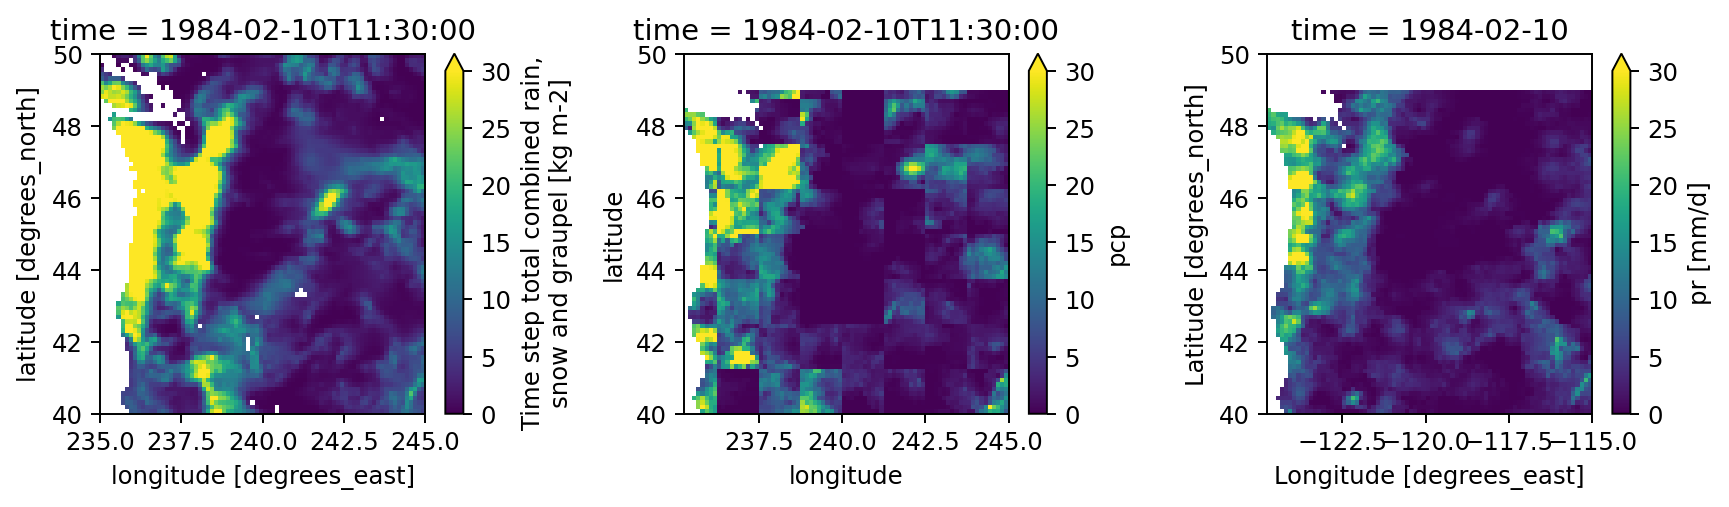

In [9]:
#full_icar,
#C_generated
#full_obs
fig = plt.figure(figsize=(10,3), dpi=175)
plt.subplot(1,3,1)
full_icar[1500].plot(vmin=0, vmax=30)
plt.subplot(1,3,2)
C_generated[1500].plot(vmax=30)
plt.subplot(1,3,3)
full_obs[1501].plot(vmax=30)
plt.tight_layout()
